In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax 
import jax.config 
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import privacy_accounting as pa
import dp_matrix_factorization.loops as loops

In [39]:
n_cats = 6
cat_edges = [5, 40, 50, 65, 72, 78]
category_names = [
    "EMPTY",
    "MANY_SEATS_AVAILABLE",
    "FEW_SEATS_AVAILABLE",
    "STANDING_ROOM_ONLY",
    "CRUSHED_STANDING_ROOM_ONLY",
    "FULL"
]
#TODO: derive this from cat_edges
category_bounds = [
    (-np.inf, 5), (6, 40), (41, 50), (51, 65), (66, 72), (73, np.inf)
]
categories = np.empty((bus_capacity+1, n_cats))
j = 0
for i in range(bus_capacity+1):
    if i > cat_edges[j]:
        j += 1
    categories[i] = np.eye(n_cats)[j]
category_codes = np.argmax(categories, axis=1)

In [148]:
n_stops = 1
bus_capacity = 78
s_matrix = np.tril(np.ones(shape=(n_stops, n_stops)))

In [149]:
results = loops.compute_h_fixed_point_iteration(
    s_matrix=jnp.array(s_matrix),
    rtol=1e-3,
    max_iterations=100,
)

In [150]:
C = results["H"]
B = results["W"]

In [151]:
max_col_norm_C = np.max(np.sqrt((C**2).sum(axis=1)))
max_data_abs_value = 1
sensitivity = 2 * max_col_norm_C * max_data_abs_value

epsilon = 1
delta = 1e-5
sigma_dp = pa.sigma(epsilon, delta, sensitivity)
noise_covariance = B @ (sigma_dp**2 * np.eye(n_stops)) @ B.transpose()
per_stop_noise_variances = noise_covariance.diagonal()

In [152]:
# stop_to_plot = 4
category_probs = np.zeros((bus_capacity + 1, n_cats))
noise_std = np.sqrt(per_stop_noise_variances.max())
for passenger_count in range(category_probs.shape[0]):
    # noise_std = np.sqrt(per_stop_noise_variances[stop_to_plot])
    noise_dist = stats.norm(loc=passenger_count, scale=noise_std)
    for category in range(n_cats):
        category_min, category_max = category_bounds[category]
        category_prob = noise_dist.cdf(category_max) - noise_dist.cdf(category_min)
        category_probs[passenger_count, category] = category_prob

In [153]:
noise_std

7.461263269631515

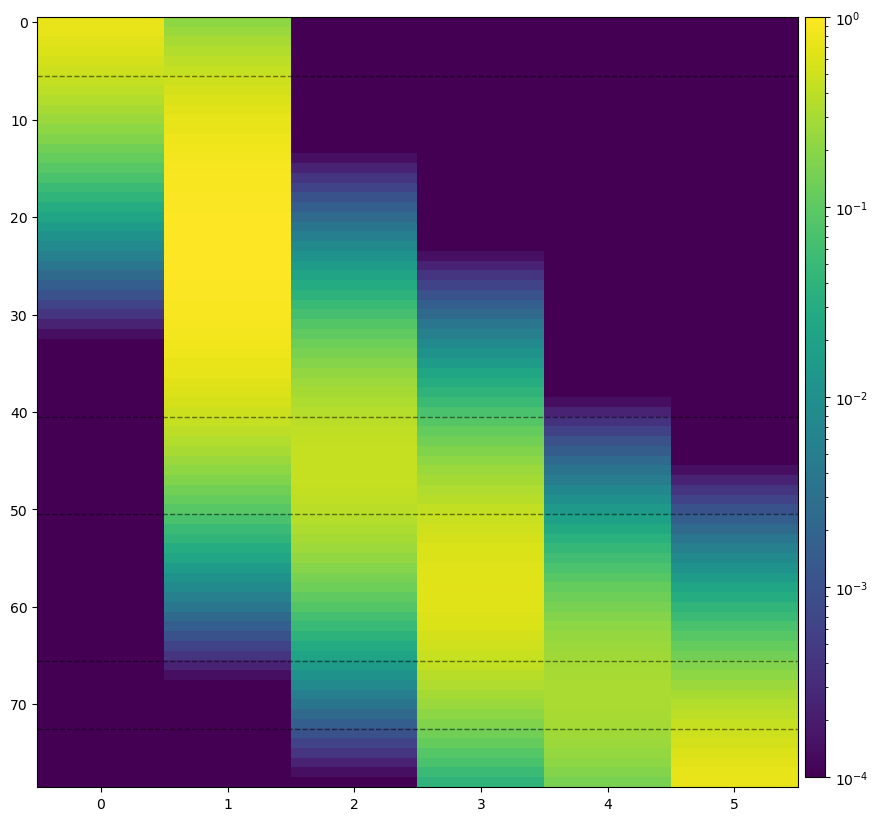

In [154]:
fig, axis = plt.subplots(figsize=(10,10))

im = axis.imshow(category_probs + 1e-16, aspect=n_cats / bus_capacity, vmin=1e-4, vmax=1., norm='log')
for edge in cat_edges[:-1]:
    axis.axhline(edge+0.5, color='k', lw=1, ls="--", alpha=0.5)
cbar_ax = fig.add_axes([0.9, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(f"probs_matrix_matrix_mech_{n_stops}.pdf", format="pdf", bbox_inches="tight")
plt.show()

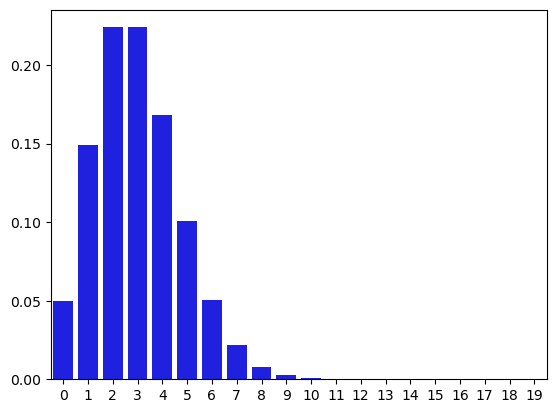

In [135]:
lambd = 3.0
xs = np.arange(20)
ys = stats.poisson.pmf(xs, lambd)
sns.barplot(x=xs, y=ys, color="blue")
plt.show()

In [136]:
current_passengers = 0
passengers_to_get_off = np.zeros(n_stops, dtype=int)
passenger_changes = np.zeros(n_stops, dtype=int)
passenger_numbers = np.zeros(n_stops, dtype=int)
for i in range(n_stops):
    passengers_before = current_passengers
    current_passengers -= passengers_to_get_off[i]
    new_passengers = np.random.poisson(lambd)
    for j in range(new_passengers):
        # Don't go over bus capacity
        if current_passengers == bus_capacity: break
        stop_to_get_off = np.random.randint(j + 1, n_stops)
        passengers_to_get_off[stop_to_get_off] += 1
        current_passengers += 1
    passenger_change = current_passengers - passengers_before
    passenger_changes[i] = passenger_change
    passenger_numbers[i] = current_passengers
    
assert((passenger_changes.cumsum() == passenger_numbers).all())

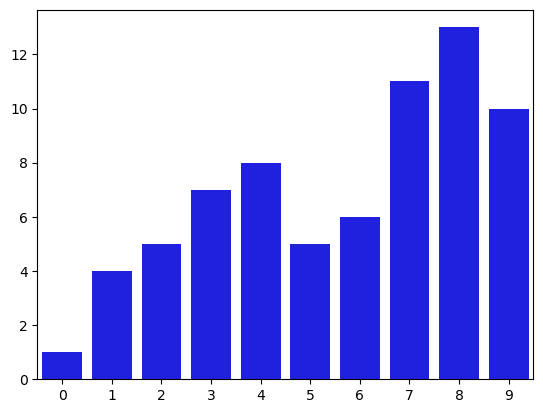

In [137]:
sns.barplot(x=np.arange(n_stops), y=passenger_numbers, color="blue")
plt.show()

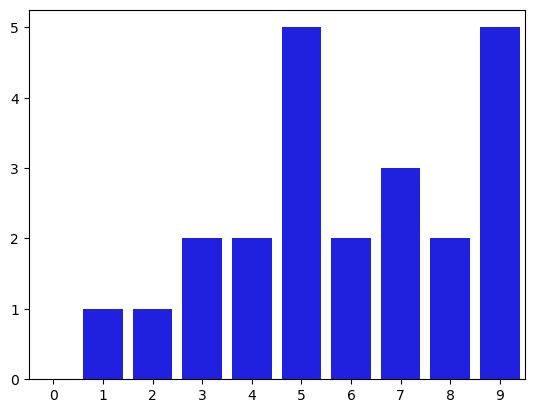

In [138]:
sns.barplot(x=np.arange(n_stops), y=passengers_to_get_off, color="blue")
plt.show()

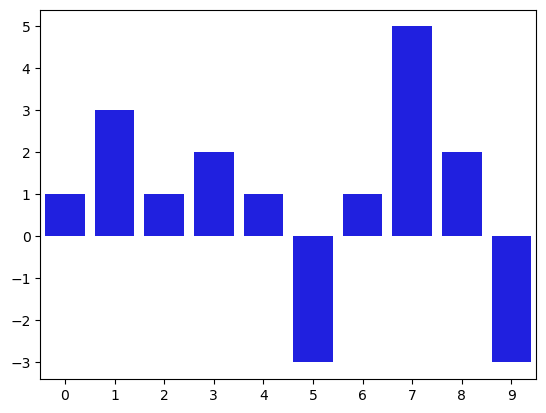

In [139]:
sns.barplot(x=np.arange(n_stops), y=passenger_changes, color="blue")
plt.show()

In [140]:
true_categories = [category_names[category_codes[count]] for count in passenger_numbers]

In [141]:
noise = np.random.normal(scale=sigma_dp, size=n_stops)
noise = np.dot(B, noise)
# noisy_changes = passenger_changes + noise
noisy_counts = passenger_numbers + noise
noisy_counts = noisy_counts.round().astype(int)
noisy_counts = np.clip(noisy_counts, 0, bus_capacity)

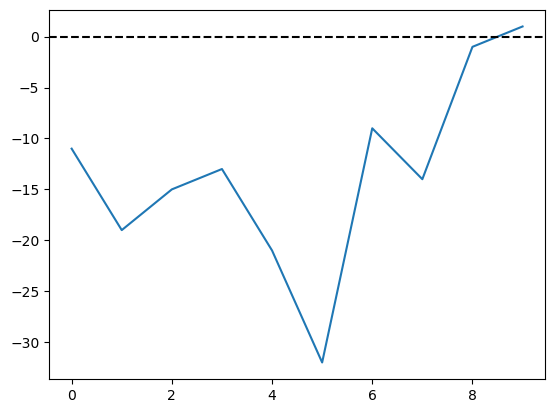

In [142]:
errors = passenger_numbers - noisy_counts
abs_errors = np.abs(errors)

plt.plot(np.arange(n_stops), errors)
plt.axhline(0, color="black", linestyle="dashed")
plt.show()

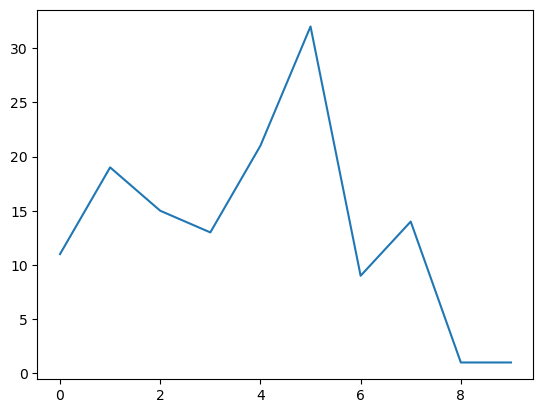

In [143]:
plt.plot(np.arange(n_stops), abs_errors)
plt.show()

In [144]:
noisy_categories = [category_names[category_codes[count]] for count in noisy_counts]

In [145]:
noisy_categories

['MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE']

In [146]:
true_categories

['EMPTY',
 'EMPTY',
 'EMPTY',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'EMPTY',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE',
 'MANY_SEATS_AVAILABLE']